# **Milestone Project 1: Food Vision Big**

By Daniel

In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
import keras
from tensorflow.keras import mixed_precision, layers, Sequential
from tensorflow.keras.layers.experimental import preprocessing

# script developed to help coding
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

import warnings
warnings.filterwarnings("ignore")

## Check GPU

We're going to make use of [Mixed Precision](https://www.tensorflow.org/guide/mixed_precision). Mixed precision is the use of both 16-bit and 32-bit floating-point types in a model during training to make it run faster and use less memory.

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Get the Data - [TensorFlow Datasets](https://www.tensorflow.org/datasets?hl=pt-br) 

Getting the data and splitting it into three subsets for training, validation and test.

In [3]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [4]:
# List all avaiable datasets
datasets_list = tfds.list_builders()
print('food101' in datasets_list)

True


In [5]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name='food101', split=['train','validation'], shuffle_files=False,
                                            as_supervised=True, # data gets returned in tuple format (data,label)
                                            with_info=True) # gets metada - ds_info

In [6]:
# Dividing data
train_size = int(0.8 * len(train_data))
val_size = int(0.2 * len(train_data))

train_ds = train_data.take(train_size)    
val_ds = train_data.skip(train_size).take(val_size)

## Exploring the Data

Informations to be collected:
* Class names
* The input data shape (image tensors)
* The datatype of the input data
* One-hot encoded or label encoded
* Labels matches with class names

In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one sample of the train data
train_one_sample = train_ds.take(1) # samples are in format (img_tensor, label)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


    Image Shape: (512, 512, 3)
    Image DataType: <dtype: 'uint8'>
    Target Class from Food101 (tensor form): 56
    Class Name (str form): huevos_rancheros
    


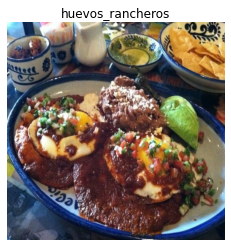

In [10]:
# Output info about our training sample
for image, label in train_one_sample:
    print(f"""
    Image Shape: {image.shape}
    Image DataType: {image.dtype}
    Target Class from Food101 (tensor form): {label}
    Class Name (str form): {class_names[label.numpy()]}
    """)
    plt.figure(figsize=(8,4))
    plt.imshow(image)
    plt.title(class_names[label.numpy()]) # add title to image to verify if the association is correct
    plt.axis(False);

In [11]:
# Tensor Image
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [12]:
# what are the min and the max values of our image tensor?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Create Preprocessing Functions for our Data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc.), but not all data comes like this. In this way, we need to create functions to preprocess our data.

About our data:
* In `uint8` datatype;
* Comprised of all different size tensors (different sized images);
* Not scaled (pixel values: 0 - 255)

Data preferable configurations:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`);
* Images reshaped to the same size;
* For batches, all of the tensors should be of the same size;
* Scaled (values between 0 & 1), or also called normalized tensors, generally performs better. 

> **Note**: EfficientNetBX architectures have `rescaling`built-in.

In [13]:
# Function to preprocess images
def preprocess_image(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes
    image to [img_shape, img_shape, colour_channels].
    """
    image = tf.image.resize(image, [img_shape,img_shape]) # reshape target image    
#     image = image/255. #scale image values (not needed for efficientnet)
    return tf.cast(image, tf.float32), label # returns (float32_image, label) tuple

In [14]:
# Preprocess a single sample image and check the outputs
preprocess_img = preprocess_image(image, label)[0]
print(f'Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDataType: {image.dtype}')
print(f'Image before preprocessing:\n {preprocess_img[:2]}..., \nShape: {preprocess_img.shape}, \nDataType: {preprocess_img.dtype}')

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]..., 
Shape: (512, 512, 3), 
DataType: <dtype: 'uint8'>
Image before preprocessing:
 [[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]..., 
Shape: (224, 224, 3), 
DataType: <dtype: 'float32'>


## Batch and Prepare Datasets 

Building an efficient data input pipeline.
More information on [Data Performance](https://www.tensorflow.org/guide/data_performance).
> **tf.data.AUTOTUNE**: Utilizes all the compute power (CPUs - processors) in order to map (process) all the instances. In version 2.3 of tensorflow, autotune is under tf.data.experimental.

In [15]:
# Train data
## Map preprocessing function to training (and parallelize)
train_ds = train_ds.map(map_func=preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
## Shuffle train_ds and turn it into batches and prefetch it (load it faster)
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Validation Data
## Map preprocessing function to validation data
val_ds = val_ds.map(map_func=preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32).\
prefetch(tf.data.experimental.AUTOTUNE)

# Test Data
## Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32).\
prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
train_ds, val_ds, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Creating Modelling Callbacks

Steps to be taken:
* TensorBoard Callback to log training results
* ModelCheckpoint callback to save our's model progress after feature extraction.
* EarlyStopping

> [Solution](https://github.com/mrdbourke/tensorflow-deep-learning/discussions/82) with Mixed Precision TF2.5+

In [25]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=0,
                                                     save_weights_only=True)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2, verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

## Setup Mixed Precision Training

Mixed precision utilizes a combination of float32 (storage) and float16 (calculations) data types to speed up model performance.

In [26]:
# Turn on mixed precision training
mixed_precision.experimental.set_policy('mixed_float16') # set global data policy to mixed precision

### **Option**: Creating Data Augmentation

We could use also data augmentation to improve our model training

In [32]:
# Create data augmentation layer to incorporate it right into the model
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
#     preprocessing.Rescaling(1./255) # not needed for this model
], name='data_augmentation')

## Build feature Extraction Model 

In [33]:
# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create Functional Model
inputs = layers.Input(shape=input_shape, name='input_layer')
# x = data_augmentation(inputs) # augment images during training
# x = preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs, training=False) # mantains layers (batch norm) in inference mode
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the Model
## loss='sparse_categorical_crossentropy' beacuse our data is not one-hot encoded
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [34]:
# Summary of our model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [35]:
# for layer in model.layers:
#     print(layer.name, layer.trainable, layer.dtype)
# mixed_precision.experimental.global_policy()

## Fit the Feature Extraction Model

Fine-tuning process:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [36]:
# Fit the base model
## using small epochs due to processing time
history_base = model.fit(train_ds, epochs=5, steps_per_epoch=len(train_ds), validation_data=val_ds, validation_steps=len(val_ds),
                         callbacks=[model_checkpoint, create_tensorboard_callback("training_logs", 'model_0')])

Saving TensorBoard log files to: training_logs/model_0/20220515-230024
Epoch 1/5
   1/1894 [..............................] - ETA: 30s - loss: 4.6953 - accuracy: 0.0000e+00WARNING:tensorflow:From C:\Users\danie\anaconda3\envs\estudo\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


1894/1894 [==============================] - 392s 207ms/step - loss: 1.9010 - accuracy: 0.5421 - val_loss: 1.4491 - val_accuracy: 0.6316
Epoch 2/5
1894/1894 [==============================] - 389s 205ms/step - loss: 1.3386 - accuracy: 0.6554 - val_loss: 1.2375 - val_accuracy: 0.6804
Epoch 3/5
1894/1894 [==============================] - 391s 207ms/step - loss: 1.1849 - accuracy: 0.6923 - val_loss: 1.1897 - val_accuracy: 0.6925
Epoch 4/5
1894/1894 [==============================] - 390s 206ms/step - loss: 1.0859 - accuracy: 0.7151 - val_loss: 1.1228 - val_accuracy: 0.7071
Epoch 5/5
1894/1894 [==============================] - 390s 206ms/step - loss: 1.0028 - accuracy: 0.7384 - val_loss: 1.0748 - val_accuracy: 0.7217


In [37]:
# Evaluate model on the test dataset
results_fe_model = model.evaluate(test_data)

790/790 [==============================] - 123s 156ms/step - loss: 1.0876 - accuracy: 0.7034


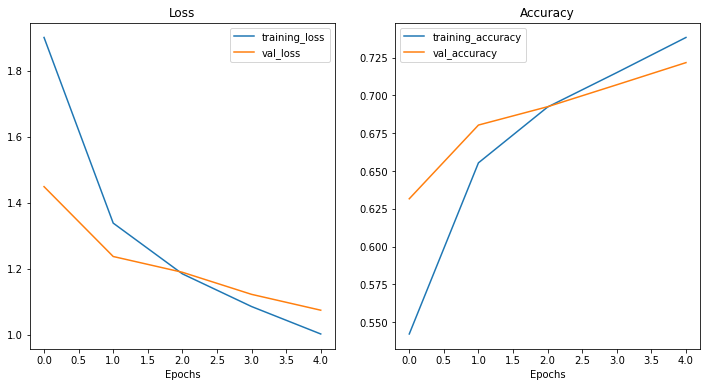

In [38]:
# Plot model loss curves
plot_loss_curves(history_base)

## Save the whole model to file

In [107]:
model.save('models')

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


## Fine-tuning the actual model

In [39]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze again all layers except the last 10
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [40]:
# In this way, we need to recompile the model in order to train again
## in fine-tuning it's typically good to lower the learning rate
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.00001), metrics=['accuracy'])

In [41]:
# model summary
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 1,022,613
Non-trainable params: 3,156,339
_________________________________________________________________


## Training again the model

In [42]:
# Fine tune for another 5 epochs
initial_epochs = 5
ft_epochs = initial_epochs + 5

# Refit the model
history_ft1 = model.fit(train_ds, epochs=ft_epochs, steps_per_epoch=len(train_ds), validation_data=val_ds, validation_steps=len(val_ds),
                       initial_epoch=history_base.epoch[-1], # star training from previous last epoch
                       callbacks=[early_stopping, model_checkpoint, reduce_lr,
                                 create_tensorboard_callback('training_logs', 'eff0_ft')])

Saving TensorBoard log files to: training_logs/eff0_ft/20220515-233513
Epoch 5/10
   2/1894 [..............................] - ETA: 1:37:29 - loss: 1.1747 - accuracy: 0.6719WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1992s vs `on_train_batch_end` time: 5.9759s). Check your callbacks.


1894/1894 [==============================] - 432s 228ms/step - loss: 0.8533 - accuracy: 0.7786 - val_loss: 1.0208 - val_accuracy: 0.7337
Epoch 6/10
1894/1894 [==============================] - 428s 226ms/step - loss: 0.8156 - accuracy: 0.7871 - val_loss: 0.9725 - val_accuracy: 0.7466: 1:28 - loss: 0.845 - ETA: 1:26 - loss: 0.845 - ETA - ETA: 1:00  - ETA: 4 - ETA: 25s  - ETA: 19s - ETA: 13s - loss: 0.8197 - accuracy: 0. - ET
Epoch 7/10
1894/1894 [==============================] - 428s 226ms/step - loss: 0.8085 - accuracy: 0.7893 - val_loss: 0.9783 - val_accuracy: 0.74284:43 - loss: 0.770 - ETA: 4:41 - - ETA: 4:39 - - E - ETA: 4:28 - los - ETA: 2:40 - loss: 0.8146 - accuracy - ETA: 2:39 - loss: 0.8165 - accu - ETA: 2:38 - loss: 0.8171  - ETA: 2:37 - - ETA: 2:34 - loss: 0 - ETA: 2:19 - loss: 0.8359 - accu - ETA: 2:18 - loss: 0.8380 - accura - ETA: 2:17 - l - E - ETA: 1:34 - loss: 0.8363 - ac - E - ETA: 1:25 - ETA: 1:22 - loss: 0.832 - ETA: 1:20 - loss: 0.8320 - accuracy: 0.78 - ETA: 1:20 

For the warning above:
[Callback method](https://stackoverflow.com/questions/66113224/tensorflowcallback-method-on-train-batch-end-is-slow-compared-to-the-batch-ti)

In [43]:
# Evaluating our model
results_ft1 = model.evaluate(test_data)

790/790 [==============================] - 122s 154ms/step - loss: 1.0277 - accuracy: 0.7225


In [44]:
# Save our fine-tuned model
model.save('models/model_1', save_format='h5')

## **A Few Notes**

* It's clear that our model improved far better than other, although it could improve much more if a few adjustments were made (more trainable layers [convolutional and fully connected], changes in learning rate parameters, and so on...)
* More tests weren't made because of the time to run and the conditions for the testing. But more could have been made.

## Loading Model and making Predictions 

In [17]:
# loading model
loaded_model = tf.keras.models.load_model('models/model_1')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
# making predictions with the model
preds_probs = loaded_model.predict(test_data, verbose=1)

  2/790 [..............................] - ETA: 1:08WARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0170s vs `on_predict_batch_end` time: 0.1400s). Check your callbacks.


790/790 [==============================] - 119s 150ms/step


In [20]:
preds_probs

array([[6.9293665e-04, 8.9807753e-07, 2.9615452e-07, ..., 9.1084803e-04,
        7.0511960e-05, 5.3588141e-02],
       [6.5681320e-06, 2.9312810e-07, 9.1904685e-06, ..., 4.6940322e-06,
        2.4454930e-04, 1.9264269e-06],
       [1.8858657e-06, 2.2747881e-06, 1.1349340e-06, ..., 1.5540715e-07,
        7.6804936e-06, 1.9876879e-07],
       ...,
       [3.6145847e-02, 8.8366787e-06, 7.0156531e-08, ..., 1.7711667e-05,
        1.4261676e-04, 5.1373608e-02],
       [9.5227890e-08, 3.5817455e-10, 3.5892835e-09, ..., 1.1537733e-10,
        9.4366415e-10, 8.0503789e-08],
       [3.3214414e-03, 7.2383780e-05, 1.0678349e-03, ..., 2.7432457e-02,
        8.9745264e-04, 2.4107478e-04]], dtype=float32)

In [21]:
# Informations about the predictions
## we get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f'Number of prediction probabilities for sample 0: {len(preds_probs[0])}')
print(f'The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}')
print(f'What prediction probability sample 0 looks like:\n {preds_probs[0]}')

Number of prediction probabilities for sample 0: 101
The class with the highest predicted probability by the model for sample 0: 29
What prediction probability sample 0 looks like:
 [6.92936650e-04 8.98077531e-07 2.96154525e-07 1.58853709e-06
 3.68680303e-05 4.60625888e-05 2.12864126e-08 4.63263677e-06
 1.38366930e-02 3.11113370e-04 2.12160870e-04 5.91102234e-09
 2.13824882e-04 7.97565212e-04 9.77197313e-04 9.50555204e-06
 9.48199071e-03 7.96127785e-03 2.33785471e-08 5.85620091e-06
 7.70942687e-09 1.80790306e-03 2.99239461e-03 1.02594298e-04
 1.74466686e-06 3.51692222e-07 1.14900155e-04 1.04022108e-03
 6.08948585e-06 6.25074506e-01 5.88263310e-02 3.14780686e-04
 2.13761064e-06 2.47819126e-10 7.67010963e-04 8.24122253e-07
 3.30581586e-03 1.57617524e-06 7.03428711e-08 1.22752647e-06
 1.20595729e-07 1.13527631e-06 2.14661748e-04 4.07970106e-07
 1.76470554e-08 1.41738549e-01 1.10664864e-07 9.66978764e-09
 4.35195898e-06 2.29814796e-05 3.54450549e-07 6.77904438e-07
 4.59658486e-06 3.1411957

In [22]:
# Getting the predictions for the first 10 classes
pred_classes = np.array(tf.argmax(preds_probs, axis = 1))

pred_classes[:10]

array([29, 81, 91, 53, 97, 97, 10, 31,  3, 94], dtype=int64)

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset.
 - unbatch the dataset and pull out the labels

In [23]:
true_categories = tf.concat([y for x, y in test_data], axis=0)
true_categories

<tf.Tensor: shape=(25250,), dtype=int64, numpy=array([29, 81, 91, ..., 76, 31, 21], dtype=int64)>

## Obtaining Classification Report 

In [24]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(true_categories, pred_classes))

              precision    recall  f1-score   support

           0       0.57      0.49      0.53       250
           1       0.75      0.68      0.72       250
           2       0.77      0.76      0.76       250
           3       0.76      0.76      0.76       250
           4       0.62      0.58      0.60       250
           5       0.63      0.61      0.62       250
           6       0.82      0.81      0.81       250
           7       0.84      0.88      0.86       250
           8       0.53      0.46      0.49       250
           9       0.65      0.63      0.64       250
          10       0.67      0.58      0.62       250
          11       0.78      0.72      0.75       250
          12       0.79      0.72      0.76       250
          13       0.67      0.72      0.69       250
          14       0.67      0.70      0.68       250
          15       0.53      0.54      0.54       250
          16       0.60      0.54      0.56       250
          17       0.71    

In [25]:
# accuracy score
print(accuracy_score(true_categories, pred_classes))

0.7225346534653465


In [26]:
# Getting a Dictionary from classification report
cr_dict = classification_report(true_categories, pred_classes, output_dict=True)

### Building F1-Scores DataFrame

In [27]:
# creating empty dictionary
f1_scores_dict = {}

# looping through classification report dictionary
for k, v in cr_dict.items():
    if k == "accuracy": # stop with accuracy key
        break
    else:
        # add class names and f1-scores to dictionay
        f1_scores_dict[class_names[int(k)]] = v['f1-score']

In [28]:
# turning dictionary to dataframe for visualization
f1_scores = pd.DataFrame({'Class Names':list(f1_scores_dict.keys()),
                         'F1-Score': list(f1_scores_dict.values())}).sort_values('F1-Score', ascending=False)
f1_scores

,Class Names,F1-Score
33,edamame,0.977867
63,macarons,0.925197
54,hot_and_sour_soup,0.891089
64,miso_soup,0.884000
69,oysters,0.881764
...,...,...
8,bread_pudding,0.494670
77,pork_chop,0.490722
22,chocolate_mousse,0.484615
39,foie_gras,0.462810


## Visualizing the Predictions on random Test Images

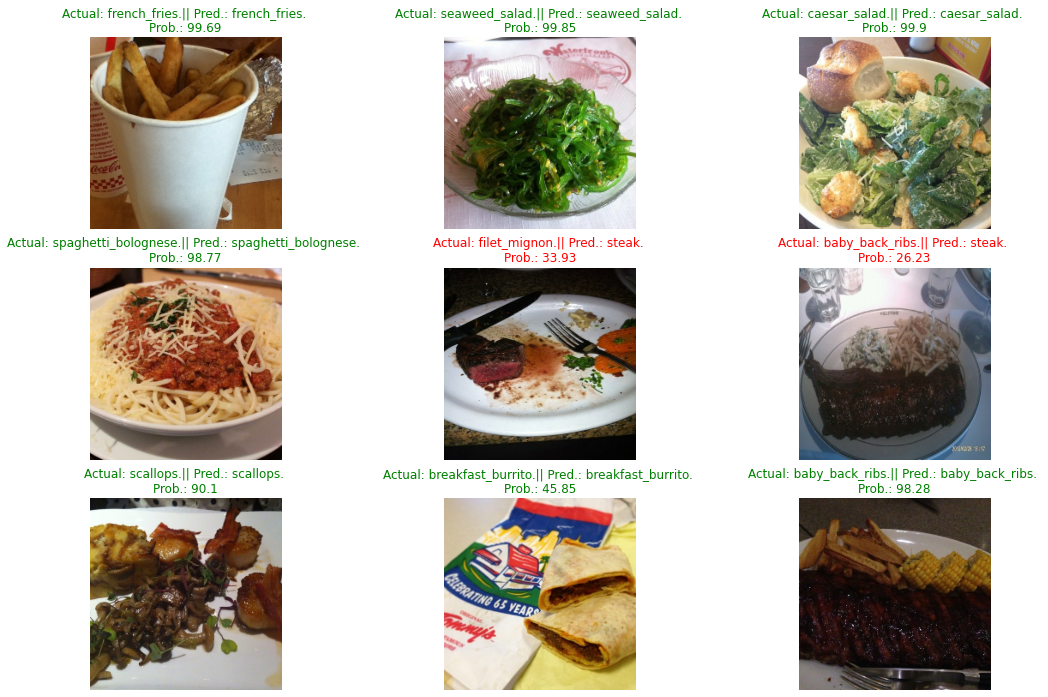

In [34]:
# taking random samples
samples = test_data.shuffle(buffer_size=100).take(9)

# taking 9 images to experiment
plt.figure(figsize=(18,12))

i = 0

for img, label in samples.unbatch():
    if i < 9:
        img = tf.image.resize(img, [224, 224])
        img = tf.cast(img, dtype = tf.float32) 
        img_exp = tf.expand_dims(img, axis =0)
        pred_prob = loaded_model.predict(img_exp)
        pred = np.array(tf.argmax(pred_prob, axis = 1))
        pred_class = class_names[pred_prob.argmax()]
        class_name = class_names[label]

        plt.subplot(3,3,i+1)
        plt.imshow(img/255)
        plt.axis(False)
        if class_name == pred_class: # if predicted class matches truth class, make text green
            title_color = 'g'
        else:
            title_color = 'r'
        plt.title(f'Actual: {class_name}.|| Pred.: {pred_class}. \nProb.: {round(pred_prob.max()*100,2)}', 
                  c=title_color)
    else:
        break
    i += 1;
    

## Identifying the Most Wrong Predictions

Finding the most wrong predictions in order to understand why the model is getting it wrong.

In [35]:
# Creating a dataframe of different parameters for each of our test images
pred_df = pd.DataFrame({'name':[class_names[i] for i in true_categories],
                       'true_value':true_categories,
                       'pred_name':[class_names[i] for i in pred_classes],
                       'pred_value':pred_classes,
                       'pred_prob':preds_probs.max(axis=1)}) # get the max prediciton value
pred_df[:10]

,name,true_value,pred_name,pred_value,pred_prob
0,cup_cakes,29,cup_cakes,29,0.625075
1,ramen,81,ramen,81,0.921531
2,spaghetti_carbonara,91,spaghetti_carbonara,91,0.960311
3,hamburger,53,hamburger,53,0.962972
4,takoyaki,97,takoyaki,97,0.928009
5,takoyaki,97,takoyaki,97,0.998094
6,bruschetta,10,bruschetta,10,0.969376
7,donuts,31,donuts,31,0.999994
8,beef_carpaccio,3,beef_carpaccio,3,0.994102
9,waffles,100,strawberry_shortcake,94,0.281593


In [36]:
# finding out which ones are wrong
pred_df['pred_correct'] = pred_df['true_value'] == pred_df['pred_value']
pred_df.head()

,name,true_value,pred_name,pred_value,pred_prob,pred_correct
0,cup_cakes,29,cup_cakes,29,0.625075,True
1,ramen,81,ramen,81,0.921531,True
2,spaghetti_carbonara,91,spaghetti_carbonara,91,0.960311,True
3,hamburger,53,hamburger,53,0.962972,True
4,takoyaki,97,takoyaki,97,0.928009,True


In [37]:
# sorting our dataframe to have the wrong predictions at the top
top_100_wrong = pred_df[pred_df['pred_correct'] == False].sort_values('pred_prob', ascending=False)
top_100_wrong.head(10)

,name,true_value,pred_name,pred_value,pred_prob,pred_correct
9735,scallops,87,deviled_eggs,30,0.999321,False
13884,garlic_bread,46,bruschetta,10,0.998789,False
14234,gyoza,52,dumplings,32,0.998691,False
23650,apple_pie,0,waffles,100,0.998361,False
16129,mussels,65,oysters,69,0.998341,False
16282,hummus,57,guacamole,51,0.998187,False
988,strawberry_shortcake,94,red_velvet_cake,83,0.998113,False
12138,ice_cream,58,poutine,78,0.997923,False
22926,sashimi,86,sushi,95,0.997695,False
6118,tuna_tartare,99,strawberry_shortcake,94,0.997060,False


### Visualizing the wrong predictions

Checking why the model is getting it wrong to make new strategies (maybe adding more images of a particular class) to make it work.

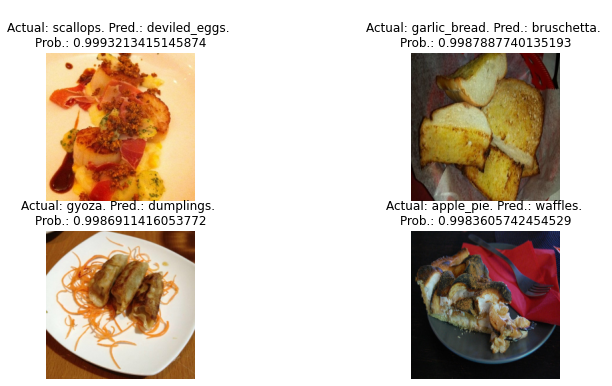

In [52]:
# checking the first 4
images_to_view = 4
start_index = 0
plt.figure(figsize=(12,6))

for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
    for img, label in test_data.unbatch():
        if label.numpy() == row[2]:
            img = tf.image.resize(img, [224, 224])
            img = tf.cast(img, dtype = tf.float32)
            pred_class = class_names[row[4]]
            class_name = class_names[label]

            plt.subplot(2,2,i+1)
            plt.imshow(img/255)
            plt.title(f'\nActual: {row[1]}. Pred.: {row[3]}. \nProb.: {row[5]}')
            plt.axis(False)